# Homework #1: AB-testing<br>and the Multi-Armed Bayesian Bandit

### You have three choices... choose wisely, my friends...


|Option|The "Red" one|The "Blue" one|The "Other" one|
|-|-|-|-|
|Unknown Probability of Success|$\theta_A$ | $\theta_B$ | $\theta_C$ |

$$p(\theta_j|x_j,n_j) \propto \theta^{x_j+\alpha_j-1}(1-\theta_j)^{n-x+\beta_j-1}  \Rightarrow \; \text{What distribution?}$$

- Try one out, and collect that data update...
    - What's the data?
    - What's the update for the posterior in question?
- Which one of the three choices will you try out? How will you choose? 


- Hints: <u>You can use *simulation* to find out the *relative belief* (i.e., probability) that each of the choices is the best.</u> Posterior distributions characterize your beliefs about the parameters $\theta_A, \theta_B$ and $\theta_C$. What can you learn by repeatedly sampling values from the posterior distribution while comparing the values of each triplet? If you know the chances that A, B, and C are the best choice, how could you balance ***exploration versus exploitation*** when choosing which of the possible options to collect the next data point on next?



## Approach

My approach to solving the task is to model our belief of the three $\theta$'s as beta distributions as in our toy model, we can easily update if we are given new data. As shown in the toy example, given a new sample drawn from the corresponding Bernouille distribution, we can do the "learning" update by incrementing $\alpha$ by 1 if it is a success and $\beta$ by 1 if it was a failure to get the new improved model. So the data is the collection of updates from all previous samples.

To decide which of our three models need to be updated and balance exploration and exploitation, I use the approach called Upper Confidence Bound (https://www.andrew.cmu.edu/course/18-847F/lectures/18687Nov182019.pdf), which means that I always choose the model with the highest value for its 97.5% percentile prediction. This will be greedy, in that it always uses the best model but also punishes large uncertainty as in those cases a failure will update the model for that $\theta$ significantly. Once the algorithm chooses the same option 25 times in a row, it terminates.

I use a weak prior of $\alpha=1, \beta=1$ for all three options.

In [57]:
from typing import Tuple, List

After 44 turns, we converged on option 2 with theta 0.8


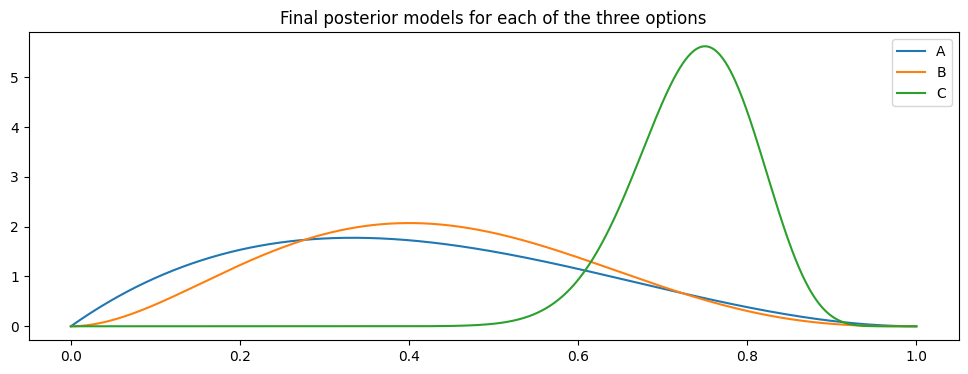

In [64]:
def run_simulation(thetas: List[int] = [0.3, 0.6, 0.8], log: bool = False) -> Tuple[int, int]:

    # we model each of the thetas as beta distributions
    # our prior is (1,1) so that we have a uniform distribution over all possible thetas
    alphas = [1, 1, 1]
    betas = [1, 1, 1]

    turns = 0
    last_taken = 0
    same_taken = 0
    required_consistency = 25  # if the thetas are closer together we might have to increase this

    # we run the simulation until we converge on a single option 10 times in a row
    while same_taken < required_consistency:
        turns += 1
        # we use upper confidence bound to select which of the three options to choose. see https://www.andrew.cmu.edu/course/18-847F/lectures/18687Nov182019.pdf
        # we use the 95% confidence interval, so we use the 97.5th percentile
        model = stats.beta(a=alphas, b=betas)
        vals = model.ppf(0.975)
        choice = np.argmax(vals)
        value = stats.bernoulli(p=thetas[choice]).rvs()
        # from above we know to update the model by increasing alpha by 1 if we get a 1 and otherwise increasing beta by 1
        alphas[choice] += value
        betas[choice] += 1 - value
        
        if choice == last_taken:
            same_taken += 1
        else:
            same_taken = 0
            last_taken = choice
        
    if log:
        print(f"After {turns} turns, we converged on option {choice} with theta {thetas[choice]}")

        plt.figure(figsize=(12,4))
        plt.plot(parameter_domain, stats.beta(a=alphas[0], b=betas[0]).pdf(parameter_domain), label="A")
        plt.plot(parameter_domain, stats.beta(a=alphas[1], b=betas[1]).pdf(parameter_domain), label="B")
        plt.plot(parameter_domain, stats.beta(a=alphas[2], b=betas[2]).pdf(parameter_domain), label="C")
        plt.legend()
        plt.title("Final posterior models for each of the three options"); 
    
    return choice, turns

_ = run_simulation(log=True)

Note that our model is still quite pessimistic about the options but it knows enough to be confident that C is better than the other options.

In [65]:
lengths = []
correct = 0
for i in range(100):
    choice, length = run_simulation()
    lengths.append(length)
    if choice == 2:
        correct += 1
print(np.mean(lengths), correct/100)

44.67 0.93


Given that we are almost always correct our stopping decision is adequately chosen.

In [68]:
correct = 0
for i in range(100):
    probs = np.random.uniform(0,1,3)
    choice, _ = run_simulation(probs)
    if choice == probs.argmax():
        correct += 1
print(correct/100)

0.87


We now evaluate with random thetas to ensure that it works for arbitrary cases. Note that if the values are closer together, it is easier for the algorithm to choose the wrong one. From the results we can see that we are still very accurate.